In [ ]:
# authenticate with the google account used in console
from google.colab import auth
auth.authenticate_user()

In [ ]:
import pandas as pd
project_id = 'emerald-ellipse-380023'

In [ ]:
# Load all tables
def load_table(table_name):
    sql = f"SELECT * FROM `bigquery-public-data.thelook_ecommerce.{table_name}`"
    return pd.io.gbq.read_gbq(sql, project_id=project_id)

users = load_table('users')
products = load_table('products')
orders = load_table('orders')
order_items = load_table('order_items')
inventory_items = load_table('inventory_items')
events = load_table('events')
distribution_centers = load_table('distribution_centers')

In [ ]:
# Merge the relevant tables
orders_items_merged = pd.merge(orders, order_items, on='order_id', suffixes=('_orders', '_order_items'))
orders_users_merged = pd.merge(orders_items_merged, users, left_on='user_id_orders', right_on='id', suffixes=('_orders', '_users'))
full_data = pd.merge(orders_users_merged, products, left_on='product_id', right_on='id', suffixes=('_orders', '_products'))

In [ ]:
# full_data.head().T


In [ ]:
# Drop redundant columns
columns_to_drop = [
     'id_orders', 'id_users',  'id',
    'user_id_order_items', 'inventory_item_id', 'status_order_items', 'created_at_order_items',
    'shipped_at_order_items', 'delivered_at_order_items', 'returned_at_order_items', 'status_orders'
]

full_data = full_data.drop(columns=columns_to_drop)


In [ ]:
# Rename columns for clarity
column_names = {
    'user_id_orders': 'user_id',
    'gender_orders': 'gender',
    'created_at_orders': 'order_created_at',
    'returned_at_orders': 'order_returned_at',
    'shipped_at_orders': 'order_shipped_at',
    'delivered_at_orders': 'order_delivered_at',
    'gender_users': 'gender',
}

full_data = full_data.rename(columns=column_names)

In [ ]:
# Calculate the total spent, total orders, and total returns per user
user_behavior = full_data.groupby('user_id').agg({'sale_price': ['sum', 'count'], 'order_returned_at': lambda x: x.notnull().sum()}).reset_index()
user_behavior.columns = ['user_id', 'total_spent', 'total_orders', 'total_returns']

In [ ]:
# Print the resulting DataFrame
print(user_behavior)

       user_id  total_spent  total_orders  total_returns
0            1   181.710003             2              0
1            2    75.809998             1              0
2            3   513.990005             6              0
3            4    32.000000             1              0
4            5   180.650000             4              0
...        ...          ...           ...            ...
79738    99993    34.000000             1              0
79739    99994    26.500000             1              1
79740    99998    84.590000             4              0
79741    99999    92.689999             2              0
79742   100000    24.990000             1              0

[79743 rows x 4 columns]


In [ ]:
# Calculate the total spent, total orders, and total returns per user
user_order_items = full_data.groupby('product_id').agg({'sale_price': ['sum', 'count'], 'order_returned_at': lambda x: x.notnull().sum()}).reset_index()
user_order_items.columns = ['product_id', 'total_spent', 'total_orders', 'total_returns']

In [ ]:
user_order_items.sort_values(by='total_spent')

,product_id,total_spent,total_orders,total_returns
14184,14235,0.04,2,1
12580,12625,4.33,1,0
14151,14202,4.50,3,0
28733,28803,4.97,1,0
5896,5917,4.99,1,0
...,...,...,...,...
24379,24447,8991.00,9,2
23580,23648,10836.00,12,1
24273,24341,11400.00,12,0
24133,24201,11739.00,13,0


In [ ]:
user_order_items['total_spent'].quantile(q=0.2)

100.0

In [ ]:
item_to_cut_id = user_order_items[user_order_items['total_spent']<100]['product_id']

In [ ]:
print(item_to_cut_id)

1            2
2            3
17          18
23          24
25          26
         ...  
29034    29104
29037    29107
29039    29109
29040    29110
29042    29112
Name: product_id, Length: 5681, dtype: Int64


In [ ]:
item_to_cut = products[products['id'].isin(item_to_cut_id)]

In [ ]:
# 20% inventory to cut

item_to_cut

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
2,27457,15.897600,Swim,TYR Sport Men's Solid Durafast Jammer Swim Suit,TYR,27.600000,Men,8F831227B0EB6C6D09A0555531365933,1
3,27466,17.850000,Swim,TYR Sport Men's Swim Short/Resistance Short Sw...,TYR,30.000000,Men,67317D6DCC4CB778AEB9219565F5456B,1
50,27813,23.639609,Swim,Hurley Men's Copy Supersuede Boardshort,Hurley,38.189999,Men,FC2208D8522B90CF01368D83DBFE9906,1
53,27834,13.134750,Swim,Hurley Blue Orange and Gray Stagger Board Shorts,Hurley,20.750000,Men,235A4B01CCA43EAD1A2435EC19C04BAB,1
107,27596,8.534600,Swim,New Men's Sexy Center Patch Bikini Swimsuit 3G...,Gregg Homme,13.900000,Men,04D81FCED5C98DD0927231751561D1FE,1
...,...,...,...,...,...,...,...,...,...
29048,2384,13.765410,Fashion Hoodies & Sweatshirts,Quiksilver Original Hoodie,Quiksilver,29.990000,Women,EA159DC9788FFAC311592613B7F71FBB,9
29076,2195,24.128000,Fashion Hoodies & Sweatshirts,Life is good. Womens Softwash Crew - LIG - Aqu...,Life Is Good,52.000000,Women,8C5F6ECD29A0EB234459190CA51C16DD,9
29097,2071,11.343500,Fashion Hoodies & Sweatshirts,VANCL Women Contrast Zipper Polar Fleece Hoodie,VANCL,24.500000,Women,FB2E203234DF6DEE15934E448EE88971,10
29102,2068,7.808250,Fashion Hoodies & Sweatshirts,Rafaella Oversized Collar V-neck Sweater,Rafaella,17.950001,Women,814A9C18F5ABFF398787C9CFCBF3D80C,10


In [ ]:
#full_data.columns

In [ ]:
user_country = pd.get_dummies(users['country'],prefix='country')

In [ ]:
user_gender = pd.get_dummies(users['gender'],prefix='sex')

In [ ]:
user_age = pd.get_dummies(pd.qcut(users['age'], q = 5, labels = range(5)),prefix='age')

In [ ]:
user_categories = pd.get_dummies(full_data['category'],prefix='cat')

In [ ]:
user_traffic = pd.get_dummies(users['traffic_source'],prefix='traffic')

In [ ]:
product_price = pd.get_dummies(pd.qcut(products['retail_price'], q = 5, labels = ['low','low-medium','medium','medium-high', 'high']),prefix='product_price')

In [ ]:
# product_brand = pd.get_dummies(products['brand'],prefix='brand')

In [ ]:
user_behavior_price = pd.get_dummies(pd.qcut(user_behavior['total_spent'], q = 5, labels = ['low','low-medium','medium','medium-high', 'high']),prefix='user_spent')

In [ ]:
user_behavior_returns = pd.get_dummies(user_behavior['total_returns'],prefix='returns')

In [ ]:
#Combine data

dfs = [  
       user_country,
       user_gender,
       user_age,
       user_categories,
       user_traffic,
       product_price,
       user_behavior_price,
       user_behavior_returns
       ]
for df in dfs:
  print(df.shape)

(100000, 16)
(100000, 2)
(100000, 5)
(180284, 26)
(100000, 5)
(29120, 5)
(79743, 5)
(79743, 8)


In [ ]:
user_all = user_categories.join(user_country,how='left').\
join(user_gender,how='left').join(user_age).join(user_traffic).\
join(product_price,how='left').\
join(user_behavior_price,how='left').\
join(user_behavior_returns,how='left')

In [ ]:
user_all.shape

(180284, 72)

In [ ]:
# user_all.head()

In [ ]:
# user_all.mean()

In [ ]:
user_all.dropna(inplace=True)

In [ ]:
user_all.head()

,cat_Accessories,cat_Active,cat_Blazers & Jackets,cat_Clothing Sets,cat_Dresses,cat_Fashion Hoodies & Sweatshirts,cat_Intimates,cat_Jeans,cat_Jumpsuits & Rompers,cat_Leggings,...,user_spent_medium-high,user_spent_high,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7
0,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# K-Menas Analysis -- Determine Optimal Number of Clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

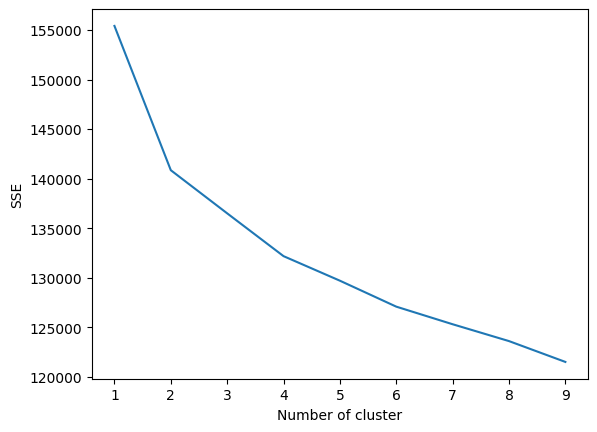

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(5)

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_all)
    #user_all["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, max_iter=1000, random_state=2).fit(user_all)
user_all["clusters"] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Examine Cluster Charactaristics

In [ ]:
cluster_means = user_all.groupby('clusters').mean()

In [ ]:
cluster_means

,cat_Accessories,cat_Active,cat_Blazers & Jackets,cat_Clothing Sets,cat_Dresses,cat_Fashion Hoodies & Sweatshirts,cat_Intimates,cat_Jeans,cat_Jumpsuits & Rompers,cat_Leggings,...,user_spent_medium-high,user_spent_high,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7
clusters,,,,,,,,,,,,,,,,,,,,,
0,0.050517,0.049751,0.031382,0.001531,0.061998,0.051282,0.158056,0.054344,0.009185,0.025641,...,0.206659,0.198240,0.848067,0.100268,0.032530,0.007654,0.009568,0.001531,0.000383,0.000000
1,0.041382,0.037043,0.035041,0.004005,0.061405,0.051060,0.157851,0.058568,0.007342,0.043050,...,0.199566,0.206407,0.852995,0.099449,0.029201,0.009177,0.008009,0.000501,0.000501,0.000167
2,0.044942,0.042922,0.034169,0.001347,0.064299,0.049150,0.158054,0.060933,0.014476,0.027605,...,0.188184,0.201481,0.850699,0.102508,0.029288,0.007070,0.009426,0.000673,0.000168,0.000168
3,0.034243,0.042948,0.034823,0.007545,0.055136,0.055717,0.172954,0.053395,0.008706,0.033082,...,0.205456,0.197911,0.849681,0.107371,0.026698,0.008125,0.007545,0.000580,0.000000,0.000000
4,0.047273,0.041877,0.034604,0.000704,0.069208,0.052434,0.148622,0.062639,0.011496,0.032845,...,0.204223,0.194604,0.851848,0.099824,0.030147,0.010088,0.007859,0.000000,0.000235,0.000000
5,0.046474,0.039769,0.033988,0.003468,0.064277,0.056647,0.153064,0.054335,0.008786,0.043468,...,0.199769,0.193526,0.849480,0.101503,0.029595,0.008786,0.008786,0.001387,0.000231,0.000231


In [ ]:
user_all.mean()

cat_Accessories          0.044986
cat_Active               0.041552
cat_Blazers & Jackets    0.034238
cat_Clothing Sets        0.002404
cat_Dresses              0.064389
                           ...   
returns_4                0.008482
returns_5                0.000618
returns_6                0.000275
returns_7                0.000103
clusters                 2.704979
Length: 73, dtype: float64

In [ ]:
percent_diff = cluster_means/user_all.mean()-1
percent_diff = percent_diff.T

In [ ]:
print(percent_diff.to_string())

clusters                                  0         1         2         3         4         5
age_0                             -0.045727  0.010343 -0.003588  0.004061 -0.006879  0.030166
age_1                             -0.010425  0.005672 -0.009931 -0.006993 -0.014652  0.043747
age_2                              0.002095  0.006820  0.013966 -0.003134  0.012035 -0.052374
age_3                              0.063149 -0.027053  0.002117  0.002708  0.002355 -0.009293
age_4                             -0.009256  0.004545 -0.002525  0.003814  0.008559 -0.015628
cat_Accessories                    0.122935 -0.080128 -0.000986 -0.238821  0.050826  0.033071
cat_Active                         0.197319 -0.108514  0.032967  0.033600  0.007813 -0.042920
cat_Blazers & Jackets             -0.083419  0.023461 -0.001995  0.017097  0.010704 -0.007278
cat_Clothing Sets                 -0.363184  0.665944 -0.439825  2.138712 -0.707214  0.442775
cat_Dresses                       -0.037134 -0.046340 -0.001

In [ ]:
cluster_names = {0:'Western Europe male fb shopper with high returns like high price item, such as Socks & Hosiery, Active and Skirts',
                 1:'male spent high amount in a single order like medium price item',
                 2:'mid-age male love buying from search',
                 3:'female like buying suits and clothing sets from display rarely returns',
                 4:'fancy spanish female like medium-high price item',
                 5:'young ladies love Fashion Hoodies & Sweatshirts and Leggings with high returns like low-medium price item'
                }

In [ ]:
user_all['clusters'].replace(cluster_names)

0                    mid-age male love buying from search
1                    mid-age male love buying from search
2                    mid-age male love buying from search
3        fancy spanish female like medium-high price item
4                    mid-age male love buying from search
                               ...                       
29115    fancy spanish female like medium-high price item
29116                mid-age male love buying from search
29117    fancy spanish female like medium-high price item
29118    fancy spanish female like medium-high price item
29119                mid-age male love buying from search
Name: clusters, Length: 29120, dtype: object